## RNN with frozen convolution layer. 

The idea is inspired by an application of RNN in predicting if an online review (say, for a product) is positive or negative (1 or 0). Each word in the review sentence is first projected to a large dimension vector space and then sent into an RNN network sequentially. 

We will make use of frozen convolution layer to create derivative like features for our time series features. Then, we use the derivative values of a certain time as if a "word" in a "review", the target RV as if the "score" of the "review" to train an RNN network that predicts the target RV with the time series features. 

## Example

In [1]:
import sys, importlib
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import time

sys.path.append("../")
from proj_mod import training, data_processing
importlib.reload(training);
importlib.reload(data_processing);

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Below is what Yuan needed to get his gpu working, do not run if you do not need it. 

Let's say, we have following timeseries feature (created randomly), we will create the derivative features first. As a reminder, the zero dimension is the batch size, the dimension one is channel (needed for the first convolution layer, not really a "thing" for time series like features). 

In [3]:
ts_feature=torch.randn(1,1,60)

In [4]:
ts_feature

tensor([[[-0.5577,  0.7130,  1.3506, -1.5546,  0.3281,  0.9122,  0.4965,
           0.6177, -1.2331,  0.9436, -0.6563, -0.2899, -0.4059,  1.1815,
          -0.5097, -0.1566, -0.7031,  1.1402,  1.0926, -0.3847,  2.3373,
          -1.5838,  0.6909, -1.1103,  0.7288, -1.7757,  0.0241,  1.0242,
          -0.6571,  0.1368, -1.3972,  0.7094, -1.1373,  0.3374,  1.7012,
           2.3106, -0.9056,  0.7240, -0.4777,  1.3106,  0.7943, -0.2757,
          -1.0394, -0.8101, -0.4421, -1.4641,  0.0069,  1.4155,  1.4152,
           0.1695,  1.4291, -0.3199, -1.9401, -2.0056,  1.0310,  1.5263,
          -0.7727,  1.3345, -0.4410, -1.9410]]])

In [5]:
conv_create_diff=training.frozen_diff_conv(n_diff=4)
ts_diff_feature=conv_create_diff(ts_feature)

In [6]:
ts_diff_feature

tensor([[[-5.5775e-01,  7.1296e-01,  1.3506e+00, -1.5546e+00,  3.2810e-01,
           9.1217e-01,  4.9651e-01,  6.1770e-01, -1.2331e+00,  9.4364e-01,
          -6.5634e-01, -2.8991e-01, -4.0593e-01,  1.1815e+00, -5.0972e-01,
          -1.5659e-01, -7.0315e-01,  1.1402e+00,  1.0926e+00, -3.8470e-01,
           2.3373e+00, -1.5838e+00,  6.9093e-01, -1.1103e+00,  7.2877e-01,
          -1.7757e+00,  2.4134e-02,  1.0242e+00, -6.5708e-01,  1.3678e-01,
          -1.3972e+00,  7.0943e-01, -1.1373e+00,  3.3745e-01,  1.7012e+00,
           2.3106e+00, -9.0558e-01,  7.2397e-01, -4.7765e-01,  1.3106e+00,
           7.9435e-01, -2.7569e-01, -1.0394e+00, -8.1008e-01, -4.4211e-01,
          -1.4641e+00,  6.9265e-03,  1.4155e+00,  1.4152e+00,  1.6947e-01,
           1.4291e+00, -3.1987e-01, -1.9401e+00, -2.0056e+00,  1.0310e+00,
           1.5263e+00, -7.7269e-01,  1.3345e+00, -4.4095e-01, -1.9410e+00],
         [ 1.2707e+00,  6.3766e-01, -2.9052e+00,  1.8827e+00,  5.8407e-01,
          -4.1565e-01,  

In [7]:
ts_diff_feature.shape

torch.Size([1, 5, 60])

We now permute the last two dimensions, essentially, this is just a transposition of the last two dimensions. 

In [8]:
ts_diff_feature=ts_diff_feature.permute(0,2,1)

In [9]:
ts_diff_feature.shape

torch.Size([1, 60, 5])

Now, this is a batch (of size 1) of timeseries feature with 60 time steps, and 5 features in each step. We then expand the 5 features, say, to 32 by projection. As a reminder, nn.Linear automatically apply to the last dimension. 

In [10]:
linear_proj=nn.Linear(5,32)
ts_feature_proj=linear_proj(ts_diff_feature)

In [11]:
ts_feature_proj.shape

torch.Size([1, 60, 32])

In this example, we will not go into too much detail, so let's make the most simple version. We then pass through a layer of RNN, then a layer of linear (to project to dimension 1 again). Learn more about RNN at https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html. 

In [12]:
RNN_layer=nn.RNN(input_size=32,hidden_size=32,num_layers=1,nonlinearity="tanh",batch_first=True,dropout=0)
linear_end=nn.Linear(32,1)

In [13]:
RNN_out=RNN_layer(ts_feature_proj)

As a reminder, since no training is done, the RNN basically just applies the initial weights. 

In [14]:
RNN_out[0].shape

torch.Size([1, 60, 32])

In [15]:
out_proj=linear_end(RNN_out[0])

In [16]:
out_proj.shape

torch.Size([1, 60, 1])

We will use sum, but we may change this to other functions, according to context or just feeling. 

In [17]:
sum_out=torch.sum(out_proj,dim=1)

In [18]:
sum_out

tensor([[15.7825]], grad_fn=<SumBackward1>)

## Creating the actual NN 

In [19]:
#Created 07/02/25
#07/02/25: Moved to training.py 
#07/08/25: Moved from training.py
class RV_RNN_conv(nn.Module):        
    #Created 07/02/25 see RNN_with_frozen_conv.ipynb for documentation. 
    #Modified 07/08/25 Added LSTM and GRU options
    def __init__(self,n_diff,rnn_num_layer,rnn_drop_out,rnn_type="rnn",rnn_act="tanh",proj_dim=32,rnn_hidden_size=32,input_scaler=10000):
        """
        :param n_diff: Decides how many derivative features is wanted in the time series. 
        :param rnn_num_layer: num_layer parameter for rnn. 
        :param rnn_drop_out: dropout parameter for rnn. 
        :param rnn_act: Defaulted to "tanh". Nonlinearity parameter for rnn. 
        :param proj_dim: Defaulted to 32. Decided the dimension of projection before feeding into rnn. 
        :param rnn_hidden_size: Defaulted to 32. The hidden_size parameter for rnn. 
        :param input_scaler: Defaulted to 10000. Set a scaling to input, a lot of timeseries values of our data are extremely close to zero. 
        :param rnn_type: 'rnn', 'lstm', or 'gru'
        """
        super().__init__()
        
        self.input_scaler=input_scaler
        self.frozen_conv=frozen_diff_conv(n_diff=n_diff)
        self.linear_proj_input=nn.Linear(n_diff+1,proj_dim)

        self.rnn_type = rnn_type

        if rnn_type == "rnn":
            self.RNN_layer=nn.RNN(input_size=proj_dim,
                                  hidden_size=rnn_hidden_size,
                                  num_layers=rnn_num_layer,
                                  nonlinearity=rnn_act,
                                  batch_first=True,
                                  dropout=rnn_drop_out)
        elif rnn_type == "lstm":
            if rnn_act is not None:
                print(f"Warning: rnn_act='{rnn_act}' is ignored when using rnn_type='lstm'")
            self.RNN_layer = nn.LSTM(input_size=proj_dim,
                                     hidden_size=rnn_hidden_size,
                                     num_layers=rnn_num_layer,
                                     batch_first=True,
                                     dropout=rnn_drop_out)
        elif rnn_type == "gru":
            if rnn_act is not None:
                print(f"Warning: rnn_act='{rnn_act}' is ignored when using rnn_type='gru'")
            self.RNN_layer = nn.GRU(input_size=proj_dim,
                                    hidden_size=rnn_hidden_size,
                                    num_layers=rnn_num_layer,
                                    batch_first=True,
                                    dropout=rnn_drop_out)
        else:
            raise ValueError(f"Unsupported rnn_type: {rnn_type}")
        
        self.linear_post_rnn=nn.Linear(rnn_hidden_size,1)
        self.frozen_list=["frozen_conv"] 
        
    def forward(self,x):
        #First, scale the input, and unsqueese to add in one dimension in dim 1 as channel. This is needed for convolution. 
        x*=self.input_scaler
        x=torch.unsqueeze(x,dim=1)
        x=self.frozen_conv(x)
        x=x.permute(0,2,1)
        x=self.linear_proj_input(x)
        x=self.RNN_layer(x)[0]
        x=self.linear_post_rnn(x)
        
        return torch.sum(x,dim=1)/self.input_scaler
    

## Basic testing on the RNN with frozen convolution 

Test it first. As a reminder, the expected input dimensions are (Batch Size, Time Series Length), this is distinct from the example above in that the channel dimension is not present. The channel dimension is added with unsqueeze at dimension 1 so that the first convolution layer can be utilized. 

In [20]:
ts_feature=torch.randn(10,60)

In [21]:
ts_feature

tensor([[ 0.3691,  0.6008, -0.7491,  0.6827, -0.0298, -0.6829,  1.1673, -0.9580,
         -0.0426,  0.9583, -0.6718,  0.8255, -0.6608, -1.0352,  0.0733, -0.5476,
         -0.2988,  1.1749, -0.9487, -1.5452,  0.5344,  0.4224, -0.3108, -0.2225,
          1.0031,  0.0261,  0.3297, -0.5437, -2.6797, -0.7719, -0.3952,  1.5811,
          0.3911, -0.0708, -0.9342, -0.1704, -0.8037, -0.1527, -0.2513,  1.2018,
          0.4559, -0.5213,  0.9909, -0.5318,  1.1439,  0.3972,  0.5222,  0.1130,
         -0.0846,  0.9227,  0.0876, -1.0440, -0.9952,  1.0073,  1.1305,  0.9681,
          0.4329,  0.2897, -1.4206,  0.2871],
        [ 0.6732,  1.4589, -0.0327,  2.3941,  0.1705,  1.4748,  0.1476,  0.4469,
         -0.5629, -0.6084, -0.1726, -0.5009,  0.2859, -0.2576, -0.2342,  0.7011,
         -0.3509,  1.1059, -1.0635,  1.4440, -1.6945,  0.8974, -0.1783,  2.0359,
          0.3362,  0.8404, -0.5280, -0.6305, -1.5888,  0.3255, -1.4203, -0.6525,
          1.1098,  0.2628, -1.3003, -0.3188, -0.8202,  0.6200, 

In [22]:
torch.unsqueeze(ts_feature,dim=1)

tensor([[[ 0.3691,  0.6008, -0.7491,  0.6827, -0.0298, -0.6829,  1.1673,
          -0.9580, -0.0426,  0.9583, -0.6718,  0.8255, -0.6608, -1.0352,
           0.0733, -0.5476, -0.2988,  1.1749, -0.9487, -1.5452,  0.5344,
           0.4224, -0.3108, -0.2225,  1.0031,  0.0261,  0.3297, -0.5437,
          -2.6797, -0.7719, -0.3952,  1.5811,  0.3911, -0.0708, -0.9342,
          -0.1704, -0.8037, -0.1527, -0.2513,  1.2018,  0.4559, -0.5213,
           0.9909, -0.5318,  1.1439,  0.3972,  0.5222,  0.1130, -0.0846,
           0.9227,  0.0876, -1.0440, -0.9952,  1.0073,  1.1305,  0.9681,
           0.4329,  0.2897, -1.4206,  0.2871]],

        [[ 0.6732,  1.4589, -0.0327,  2.3941,  0.1705,  1.4748,  0.1476,
           0.4469, -0.5629, -0.6084, -0.1726, -0.5009,  0.2859, -0.2576,
          -0.2342,  0.7011, -0.3509,  1.1059, -1.0635,  1.4440, -1.6945,
           0.8974, -0.1783,  2.0359,  0.3362,  0.8404, -0.5280, -0.6305,
          -1.5888,  0.3255, -1.4203, -0.6525,  1.1098,  0.2628, -1.3003,
  

In [23]:
model=training.RV_RNN_conv(n_diff=4,rnn_act="tanh",rnn_num_layer=2,rnn_drop_out=0.3,rnn_hidden_size=32,proj_dim=32)

In [24]:
out=model(ts_feature)

In [25]:
out

tensor([[-0.0005],
        [-0.0005],
        [-0.0007],
        [-0.0006],
        [-0.0005],
        [-0.0003],
        [-0.0002],
        [-0.0004],
        [-0.0005],
        [-0.0008]], grad_fn=<DivBackward0>)

## Training loop (basic) 

In [26]:
list_time=np.load("../processed_data/recovered_time_id_order.npy")

In [27]:
print(list_time)

[ 4294 31984 31570 ... 29316 32195 10890]


In [28]:
time_split_list=data_processing.time_cross_val_split(list_time=list_time,n_split=1,percent_val_size=10,list_output=True)

In fold 0 :

Train set end at 8117 .

Test set start at 15516 end at 10890 .



In [29]:
time_split_list[0][0]

array([ 4294, 31984, 31570, ...,  5629, 10421,  8117])

In [30]:
time_split_list[0][1]

array([15516, 30276, 16402, 27182, 24497, 13529,   373,  4219, 20323,
        9160, 28983, 17820, 22678,  7460, 29676, 32048, 22405, 31380,
        1816, 14079, 29944, 21990, 26804, 28210, 18142, 11682, 32597,
       13513, 32690, 27120, 27427,  7418,  1213,  9822, 29692, 24523,
       25318,  6274, 25569, 12713,   169, 20732, 15906, 28877, 25551,
       10745, 31320, 31714,  6076, 23656,   424,   309, 17604, 28963,
       23144, 11872, 29219, 25357, 22828, 17569, 17955, 11920, 18509,
       19626, 16149,  5392,  7200, 10929,  4774, 27278, 23639, 10633,
          72, 32534, 26944, 31018, 26494,  6648,   709,  6823, 21239,
       11995, 23265, 31883,  2711,  1350,  1321, 16282,  5046, 29875,
        7133, 15823, 25463,  9064,  3333, 11440, 16831,  6815, 19580,
       30620, 24014, 17193, 10708, 30597,  4367, 27962, 13010, 32254,
       23226, 22903,  5929, 30327,  1866, 14629,  1205,  9352, 10619,
       14234, 15276,  4091, 22752, 18653, 11453, 26708, 30183, 13986,
           5,  7864,

In [31]:
train_time_id,test_time_id=time_split_list[0][0],time_split_list[0][1]

In [32]:
df_RV_ts=pd.read_parquet("../processed_data/book_RV_ts_60_si.parquet")

In [33]:
from sklearn.preprocessing import StandardScaler

In [34]:
scalar=StandardScaler()

In [35]:
df_RV_ts["sub_int_RV_norm"]=scalar.fit_transform(df_RV_ts[["sub_int_RV"]])

In [36]:
df_RV_ts

,time_id,sub_int_RV,sub_int_num,stock_id,row_id,sub_int_RV_norm
0,5,0.000329,1,93,93-5,-0.208285
1,11,0.000191,1,93,93-11,-0.453866
2,16,0.000126,1,93,93-16,-0.569259
3,31,0.000205,1,93,93-31,-0.428690
4,62,0.000142,1,93,93-62,-0.540259
...,...,...,...,...,...,...
25735915,32686,0.000000,60,104,104-32686,-0.793956
25735916,32690,0.000000,60,104,104-32690,-0.793956
25735917,32712,0.000000,60,104,104-32712,-0.793956
25735918,32746,0.000000,60,104,104-32746,-0.793956


In [37]:
df_RV_ts.pivot(index="row_id",columns=["sub_int_num"],values=["sub_int_RV"])

sub_int_RV                                                        \
sub_int_num         1         2         3         4         5             6    
row_id                                                                         
0-1000        0.000341  0.000000  0.000023  0.000000  0.000170  3.818799e-07   
0-10000       0.000290  0.000191  0.000087  0.000193  0.000241  3.154886e-04   
0-10005       0.000000  0.000000  0.001554  0.002177  0.002303  4.375100e-04   
0-10017       0.000142  0.000142  0.001464  0.001086  0.000068  6.771948e-05   
0-10030       0.000327  0.000058  0.000293  0.000842  0.000120  2.586782e-04   
...                ...       ...       ...       ...       ...           ...   
99-9972       0.000197  0.000181  0.000171  0.000172  0.000369  2.503467e-04   
99-9973       0.000821  0.000346  0.000691  0.001591  0.000863  9.650211e-04   
99-9976       0.000569  0.001101  0.001002  0.000430  0.000797  7.203531e-04   
99-9988       0.000040  0.000069  0.000123  0.000056  0.000016  1.957402e-04   
99-9993       0.000249  0.000179  0.000155  0.000025  0.000325  1.798617e-04   

                                                     ...                      \
sub_int_num        7         8         9         10  ...        51        52   
row_id                                               ...                       
0-1000       0.000089  0.000552  0.000012  0.000000  ...  0.000265  0.000000   
0-10000      0.000000  0.000247  0.000265  0.000000  ...  0.000202  0.000375   
0-10005      0.000617  0.001199  0.002306  0.001215  ...  0.000000  0.000486   
0-10017      0.000899  0.000064  0.000593  0.000451  ...  0.000029  0.000000   
0-10030      0.000221  0.000436  0.000099  0.000008  ...  0.000410  0.000437   
...               ...       ...       ...       ...  ...       ...       ...   
99-9972      0.000349  0.000356  0.000390  0.000050  ...  0.000075  0.000185   
99-9973      0.000504  0.001925  0.000641  0.000382  ...  0.001081  0.001095   
99-9976      0.000586  0.000538  0.000570  0.000781  ...  0.000508  0.000406   
99-9988      0.000071  0.000095  0.000063  0.000030  ...  0.000034  0.000176   
99-9993      0.000080  0.000125  0.000126  0.000205  ...  0.000099  0.000370   

                                                                   \
sub_int_num        53        54        55        56            57   
row_id                                                              
0-1000       0.000214  0.000003  0.000000  0.000118  2.313288e-04   
0-10000      0.000616  0.000564  0.000000  0.000023  3.777703e-08   
0-10005      0.000050  0.001761  0.001617  0.001801  2.552987e-03   
0-10017      0.001293  0.002092  0.000994  0.000848  3.104404e-03   
0-10030      0.000004  0.000215  0.000457  0.000183  4.842470e-04   
...               ...       ...       ...       ...           ...   
99-9972      0.000314  0.000318  0.000115  0.000143  9.916624e-05   
99-9973      0.000425  0.000789  0.001295  0.000596  1.862600e-03   
99-9976      0.000662  0.000338  0.000710  0.000179  5.946683e-04   
99-9988      0.000140  0.000129  0.000175  0.000019  1.440137e-04   
99-9993      0.000929  0.000328  0.000251  0.000204  2.728767e-04   

                                               
sub_int_num            58        59        60  
row_id                                         
0-1000       1.060893e-05  0.000111  0.000288  
0-10000      3.777703e-08  0.000020  0.000310  
0-10005      5.364106e-04  0.000872  0.000000  
0-10017      1.224910e-03  0.001316  0.003287  
0-10030      0.000000e+00  0.000756  0.000005  
...                   ...       ...       ...  
99-9972      1.809852e-04  0.000334  0.000089  
99-9973      7.668418e-04  0.001035  0.002115  
99-9976      1.509652e-04  0.000388  0.000403  
99-9988      3.200939e-05  0.000041  0.000007  
99-9993      2.108380e-04  0.000126  0.000353  

[428932 rows x 60 columns]

In [38]:
df_target=pd.read_csv("../raw_data/kaggle_ORVP/train.csv")

In [39]:
df_target["row_id"]=df_target["stock_id"].astype(int).astype(str)+"-"+df_target["time_id"].astype(int).astype(str)

In [40]:
df_target

,stock_id,time_id,target,row_id
0,0,5,0.004136,0-5
1,0,11,0.001445,0-11
2,0,16,0.002168,0-16
3,0,31,0.002195,0-31
4,0,62,0.001747,0-62
...,...,...,...,...
428927,126,32751,0.003461,126-32751
428928,126,32753,0.003113,126-32753
428929,126,32758,0.004070,126-32758
428930,126,32763,0.003357,126-32763


In [41]:
train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV"],df_ts_feat=df_RV_ts,df_target=df_target)
test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV"],df_ts_feat=df_RV_ts,df_target=df_target)

/home/machine2/Desktop/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy["sub_int_num"]=np.nan
/home/machine2/Desktop/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy["sub_int_num"]=np.nan


In [42]:
train_dataset.features.shape

torch.Size([386036, 60])

In [43]:
train_dataset.target.shape

torch.Size([386036, 1])

Not entirely sure what the error code is about, I am literally doing exactly as suggested by the warning. https://stackoverflow.com/questions/23688307/settingwithcopywarning-even-when-using-loc says this is a false positive. 

## Experiment: RNN (with some fine tuning), LSTM, and linear regression

In [44]:
time_split_list=data_processing.time_cross_val_split(list_time=list_time,n_split=1,percent_val_size=10,list_output=True)
train_time_id,test_time_id=time_split_list[0][0],time_split_list[0][1]

train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV"],df_ts_feat=df_RV_ts,df_target=df_target)
test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV"],df_ts_feat=df_RV_ts,df_target=df_target)

In fold 0 :

Train set end at 8117 .

Test set start at 15516 end at 10890 .



/home/machine2/Desktop/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy["sub_int_num"]=np.nan
/home/machine2/Desktop/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy["sub_int_num"]=np.nan


RNN

In [45]:
RNN_model=training.RV_RNN_conv(n_diff=2, rnn_type="rnn",rnn_act="tanh",rnn_drop_out=0,rnn_hidden_size=32,proj_dim=32,rnn_num_layer=1,input_scaler=10000).to(device=device)

import torch.optim as optim

optimizer=optim.Adam(RNN_model.parameters(),lr=1e-3)

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

train_loss=[]
val_loss=[]

training.reg_training_loop_rmspe(optimizer=optimizer,model=RNN_model,train_loader=train_loader,val_loader=test_loader,list_train_loss=train_loss,list_val_loss=val_loss,device=device,n_epochs=100,ot_steps=10,report_interval=5,eps=0,scaler=1)

At  1.2836482524871826  epoch  1 has training loss  tensor(0.2619, device='cuda:0')  and validation loss  tensor(0.2423, device='cuda:0') .

At  6.662927627563477  epoch  5 has training loss  tensor(0.2547, device='cuda:0')  and validation loss  tensor(0.2368, device='cuda:0') .

At  12.984842538833618  epoch  10 has training loss  tensor(0.2536, device='cuda:0')  and validation loss  tensor(0.2351, device='cuda:0') .

At  19.630865812301636  epoch  15 has training loss  tensor(0.2527, device='cuda:0')  and validation loss  tensor(0.2357, device='cuda:0') .

At  26.094637393951416  epoch  20 has training loss  tensor(0.2527, device='cuda:0')  and validation loss  tensor(0.2357, device='cuda:0') .

The validation loss has not improved for  10  epochs. Stopping current training loop.

Best model state dictionary of this training loop is reloaded.

According to validation loss, the best model is reached at epoch 14  with validation loss:  tensor(0.2348, device='cuda:0') .
 The total numbe

OrderedDict([('frozen_conv.frozen_conv.weight',
              tensor([[[-1.,  1.]]], device='cuda:0')),
             ('linear_proj_input.weight',
              tensor([[ 0.0534,  0.2919, -0.3057],
                      [ 0.0650,  0.0654, -0.2658],
                      [ 0.0175,  0.2920,  0.2604],
                      [-0.4015,  0.4187,  0.5416],
                      [-0.0904, -0.2123, -0.3803],
                      [-0.1478,  0.3972, -0.3277],
                      [ 0.5207,  0.7690,  0.4038],
                      [ 0.0969, -0.2740, -0.5250],
                      [-0.0276, -0.5302, -0.1606],
                      [-0.2822, -0.2647,  0.5187],
                      [ 0.0045, -0.3951, -0.1687],
                      [ 0.5052,  0.1409,  0.3657],
                      [ 0.0687,  0.5994,  0.2664],
                      [-0.3185, -0.3795,  0.4575],
                      [ 0.2545,  0.3227,  0.0565],
                      [-0.0836, -0.1112, -0.0495],
                      [-0.1078,  0.291

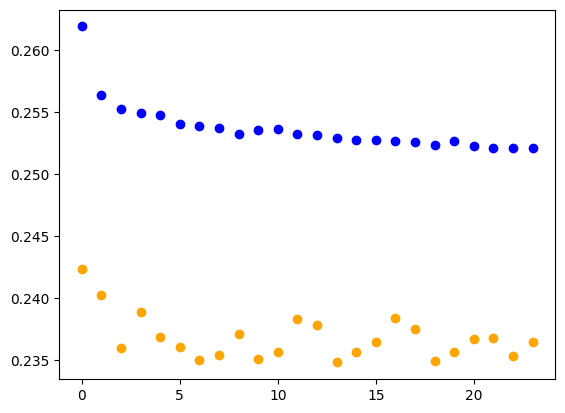

In [46]:
train_loss=[x.cpu() for x in train_loss]
val_loss=[x.cpu() for x in val_loss]

import matplotlib.pyplot as plt 

x=np.arange(len(train_loss))

plt.scatter(x,train_loss,c="blue")
plt.scatter(x,val_loss,c="orange")

LSTM:

In [47]:
RNN_model=training.RV_RNN_conv(n_diff=2, rnn_type="lstm",rnn_act="tanh",rnn_drop_out=0,rnn_hidden_size=32,proj_dim=32,rnn_num_layer=1,input_scaler=10000).to(device=device)

import torch.optim as optim

optimizer=optim.Adam(RNN_model.parameters(),lr=1e-3)

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

train_loss=[]
val_loss=[]

training.reg_training_loop_rmspe(optimizer=optimizer,model=RNN_model,train_loader=train_loader,val_loader=test_loader,list_train_loss=train_loss,list_val_loss=val_loss,device=device,n_epochs=100,ot_steps=10,report_interval=5,eps=0,scaler=1)

At  1.0748326778411865  epoch  1 has training loss  tensor(0.2743, device='cuda:0')  and validation loss  tensor(0.2365, device='cuda:0') .

At  6.18251633644104  epoch  5 has training loss  tensor(0.2503, device='cuda:0')  and validation loss  tensor(0.2335, device='cuda:0') .

At  12.641299962997437  epoch  10 has training loss  tensor(0.2477, device='cuda:0')  and validation loss  tensor(0.2336, device='cuda:0') .

At  19.42552661895752  epoch  15 has training loss  tensor(0.2458, device='cuda:0')  and validation loss  tensor(0.2312, device='cuda:0') .

At  26.10793972015381  epoch  20 has training loss  tensor(0.2452, device='cuda:0')  and validation loss  tensor(0.2344, device='cuda:0') .

At  32.48069524765015  epoch  25 has training loss  tensor(0.2447, device='cuda:0')  and validation loss  tensor(0.2304, device='cuda:0') .

At  38.90877842903137  epoch  30 has training loss  tensor(0.2443, device='cuda:0')  and validation loss  tensor(0.2304, device='cuda:0') .

At  45.3929524

OrderedDict([('frozen_conv.frozen_conv.weight',
              tensor([[[-1.,  1.]]], device='cuda:0')),
             ('linear_proj_input.weight',
              tensor([[ 0.0069,  0.1811,  0.1279],
                      [ 0.2459,  0.4032,  0.2393],
                      [-0.2490, -0.3000, -0.2406],
                      [-0.1185,  0.1376,  0.0902],
                      [ 0.2450, -0.0417, -0.2803],
                      [ 0.0578,  0.1179, -0.0844],
                      [-0.0424,  0.0367,  0.1358],
                      [-0.1225, -0.4786, -0.1143],
                      [-0.0425, -0.0565, -0.0021],
                      [-0.0367,  0.2773,  0.1936],
                      [ 0.2026, -0.6658, -0.3960],
                      [ 0.2435, -0.0487, -0.2872],
                      [ 0.2213, -0.2336,  0.1110],
                      [ 0.0607, -0.2668,  0.1187],
                      [ 0.1262, -0.0500, -0.0125],
                      [ 0.0250,  0.3876,  0.2328],
                      [-0.0094,  0.011

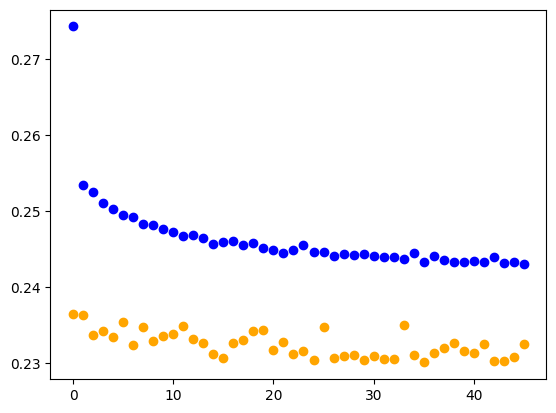

In [48]:
train_loss=[x.cpu() for x in train_loss]
val_loss=[x.cpu() for x in val_loss]

import matplotlib.pyplot as plt 

x=np.arange(len(train_loss))

plt.scatter(x,train_loss,c="blue")
plt.scatter(x,val_loss,c="orange")

Baseline Model

In [49]:
# First build an approximate RV feature
path_book="../raw_data/kaggle_ORVP/book_train.parquet"
df_rv=data_processing.create_df_RV_by_row_id_parallel(path_book)

# Then merge with target dataframe
df_rv_target=pd.merge(df_target, df_rv, on=["row_id","time_id","stock_id"])

train_dataset_base = df_rv_target.loc[df_rv_target['time_id'].isin(train_time_id), ['RV','target','row_id']].set_index('row_id')
test_dataset_base = df_rv_target.loc[df_rv_target['time_id'].isin(test_time_id), ['RV','target','row_id']].set_index('row_id')

In [50]:
from sklearn.linear_model import LinearRegression

X_train=train_dataset_base[['RV']]
y_train=train_dataset_base['target']

X_test=test_dataset_base[['RV']]
y_test=test_dataset_base['target']

model= LinearRegression()
model.fit(X_train,y_train)

training_loss = training.rmspe(model.predict(X_train),y_train)
validation_loss = training.rmspe(model.predict(X_test),y_test)

print("The losses for training and validation data are: {:.4f} and {:.4f}".format(training_loss, validation_loss))

The losses for training and validation data are: 0.3019 and 0.2678


## Training with native values, with a 10000 times scaler on input. 

A key issue with our input timeseries is that all values are extremely close to zero, so a 10000 times scaler can help with expanding them a little. 

In [51]:
device=(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Using device {device}")

Using device cuda


In [52]:
RNN_model=training.RV_RNN_conv(n_diff=4,rnn_act="tanh",rnn_drop_out=0,rnn_hidden_size=32,proj_dim=32,rnn_num_layer=1,input_scaler=10000).to(device=device)

In [53]:
import torch.optim as optim

optimizer=optim.Adam(RNN_model.parameters(),lr=1e-3)

In [54]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=256,shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=256,shuffle=True)

In [55]:
train_loss=[]
val_loss=[]

In [56]:
training.reg_training_loop_rmspe(optimizer=optimizer,model=RNN_model,train_loader=train_loader,val_loader=test_loader,list_train_loss=train_loss,list_val_loss=val_loss,device=device,n_epochs=100,ot_steps=10,report_interval=5,eps=0,scaler=1)

At  2.4124667644500732  epoch  1 has training loss  tensor(0.2708, device='cuda:0')  and validation loss  tensor(0.2384, device='cuda:0') .

At  12.776042699813843  epoch  5 has training loss  tensor(0.2543, device='cuda:0')  and validation loss  tensor(0.2427, device='cuda:0') .

At  25.39820647239685  epoch  10 has training loss  tensor(0.2535, device='cuda:0')  and validation loss  tensor(0.2367, device='cuda:0') .

The validation loss has not improved for  10  epochs. Stopping current training loop.

Best model state dictionary of this training loop is reloaded.

According to validation loss, the best model is reached at epoch 4  with validation loss:  tensor(0.2355, device='cuda:0') .
 The total number of epoch trained is  14 .
 Training completed in:  35.43797254562378 .



OrderedDict([('frozen_conv.frozen_conv.weight',
              tensor([[[-1.,  1.]]], device='cuda:0')),
             ('linear_proj_input.weight',
              tensor([[-0.0025,  0.3429, -0.3135, -0.3415,  0.0344],
                      [-0.3418, -0.2520,  0.3134,  0.0784, -0.0113],
                      [-0.0905,  0.0536,  0.2372,  0.2678,  0.2170],
                      [ 0.1711,  0.4248,  0.1065,  0.3274,  0.2058],
                      [ 0.1589, -0.0608,  0.2764,  0.5181,  0.2483],
                      [ 0.2800,  0.2423,  0.2475,  0.1755, -0.2207],
                      [ 0.0426,  0.0317,  0.0968,  0.2307,  0.1035],
                      [-0.2158, -0.1542, -0.5177, -0.2377,  0.2228],
                      [ 0.1103,  0.1349,  0.4890,  0.3527,  0.0660],
                      [ 0.0250, -0.0797, -0.2141,  0.0243,  0.0511],
                      [-0.3591, -0.4367, -0.2663, -0.3177, -0.1018],
                      [ 0.0740, -0.3691, -0.1955, -0.2974, -0.2060],
                      [ 0.

In [57]:
for name,param in RNN_model.named_parameters():
    print(name,param.requires_grad)

frozen_conv.frozen_conv.weight False
linear_proj_input.weight True
linear_proj_input.bias True
RNN_layer.weight_ih_l0 True
RNN_layer.weight_hh_l0 True
RNN_layer.bias_ih_l0 True
RNN_layer.bias_hh_l0 True
linear_post_rnn.weight True
linear_post_rnn.bias True


In [58]:
train_loss=[x.cpu() for x in train_loss]
val_loss=[x.cpu() for x in val_loss]

Above is an example of the training. 

In [59]:
import matplotlib.pyplot as plt 

x=np.arange(len(train_loss))

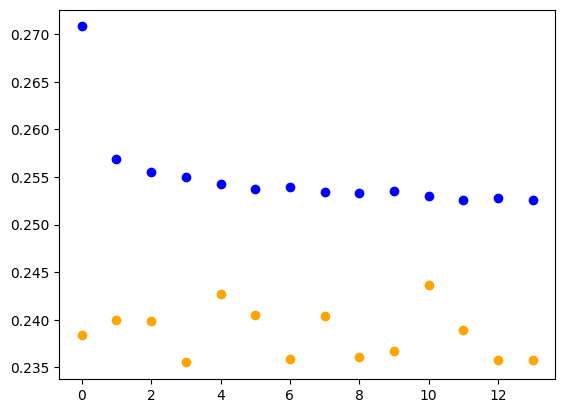

In [60]:
plt.scatter(x,train_loss,c="blue")
plt.scatter(x,val_loss,c="orange")

## Try to normalize only the input. 

In [61]:
RNN_model_norm_ts=training.RV_RNN_conv(n_diff=4,rnn_act="tanh",rnn_drop_out=0,rnn_hidden_size=32,proj_dim=32,rnn_num_layer=1,input_scaler=1).to(device=device)

In [62]:
optimizer_norm_ts=optim.Adam(RNN_model_norm_ts.parameters(),lr=1e-3)

In [63]:
train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV_norm"],df_ts_feat=df_RV_ts,df_target=df_target)
test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV_norm"],df_ts_feat=df_RV_ts,df_target=df_target)

/home/machine2/Desktop/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy["sub_int_num"]=np.nan
/home/machine2/Desktop/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy["sub_int_num"]=np.nan


In [64]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=256,shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=256,shuffle=True)

In [65]:
train_loss=[]
val_loss=[]

In [66]:
training.reg_training_loop_rmspe(optimizer=optimizer_norm_ts,model=RNN_model_norm_ts,train_loader=train_loader,val_loader=test_loader,list_train_loss=train_loss,list_val_loss=val_loss,device=device,n_epochs=200,ot_steps=20,report_interval=5,eps=0,scaler=1)

At  2.3960013389587402  epoch  1 has training loss  tensor(284.9402, device='cuda:0')  and validation loss  tensor(12.9999, device='cuda:0') .

At  12.366611242294312  epoch  5 has training loss  tensor(23.0415, device='cuda:0')  and validation loss  tensor(13.2517, device='cuda:0') .

At  25.075587034225464  epoch  10 has training loss  tensor(14.2988, device='cuda:0')  and validation loss  tensor(4.0947, device='cuda:0') .

At  37.931830406188965  epoch  15 has training loss  tensor(11.1785, device='cuda:0')  and validation loss  tensor(10.6493, device='cuda:0') .

At  51.06553649902344  epoch  20 has training loss  tensor(8.5535, device='cuda:0')  and validation loss  tensor(4.9181, device='cuda:0') .

At  64.10282301902771  epoch  25 has training loss  tensor(7.1558, device='cuda:0')  and validation loss  tensor(6.0890, device='cuda:0') .

At  76.88521456718445  epoch  30 has training loss  tensor(8.1487, device='cuda:0')  and validation loss  tensor(6.0491, device='cuda:0') .

At 

OrderedDict([('frozen_conv.frozen_conv.weight',
              tensor([[[-1.,  1.]]], device='cuda:0')),
             ('linear_proj_input.weight',
              tensor([[ 0.3186,  0.1845, -0.1395, -0.1375, -0.1039],
                      [ 0.0506,  0.0708,  0.4410, -0.2497, -0.1732],
                      [-0.0100, -0.0899,  0.0360, -0.0640, -0.0462],
                      [-0.0792, -0.0444,  0.3355, -0.2384,  0.0049],
                      [-0.0320,  0.6086, -0.0610, -0.1013, -0.1538],
                      [-0.2306, -0.2493, -0.2432,  0.1330,  0.1080],
                      [-0.0303,  0.0970, -0.2825, -0.0410,  0.0820],
                      [ 0.0065, -0.2076, -0.1258, -0.0473, -0.0814],
                      [-0.0928,  0.1704, -0.2404, -0.0216, -0.1829],
                      [ 0.0984, -0.3246,  0.3306,  0.0594,  0.0576],
                      [-0.0158,  0.1499, -0.3494,  0.1280,  0.1238],
                      [-0.2787,  0.1843, -0.2477,  0.0438,  0.0326],
                      [ 0.

As a remark, I ran above loop twice, the keep learning to same model after the fact. 

In [67]:
for name,param in RNN_model_norm_ts.named_parameters():
    print(name,param.requires_grad)

frozen_conv.frozen_conv.weight False
linear_proj_input.weight True
linear_proj_input.bias True
RNN_layer.weight_ih_l0 True
RNN_layer.weight_hh_l0 True
RNN_layer.bias_ih_l0 True
RNN_layer.bias_hh_l0 True
linear_post_rnn.weight True
linear_post_rnn.bias True


In [68]:
train_loss=[x.cpu() for x in train_loss]
val_loss=[x.cpu() for x in val_loss]

In [69]:
len(train_loss)

51

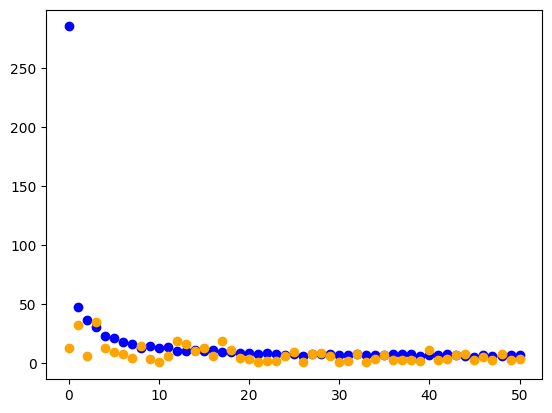

In [70]:
import matplotlib.pyplot as plt 

x=np.arange(len(train_loss))

plt.scatter(x,train_loss,c="blue")
plt.scatter(x,val_loss,c="orange")

It appears that only normalizing input ts is not a good idea. I should consider normalizing both the input and the target. Plus, in above, I fit transformed on both the training and the test set together, that is technically a data leak. 

## Training with normalization on both input and target 

I have added normalization functionality to dataset creation function, so not we can create the train and test datasets without dataleaking. 

In [98]:
RNN_model_norm_ts=training.RV_RNN_conv(n_diff=4,rnn_act="tanh",rnn_drop_out=0,rnn_hidden_size=32,proj_dim=32,rnn_num_layer=1,input_scaler=1).to(device=device)

In [99]:
optimizer_norm_ts=optim.Adam(RNN_model_norm_ts.parameters(),lr=1e-3)

In [100]:
train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV"],df_ts_feat=df_RV_ts,df_target=df_target,norm_feature_dict={"sub_int_RV":None,"target":None})

/home/machine2/Desktop/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy["sub_int_num"]=np.nan


Notice: sub_int_RV has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: target has been normalized.
The mean and std of this feature has been stored in feat_norm_dict


In [101]:
train_dataset.feat_norm_dict

{'sub_int_RV': (np.float64(0.0004411965933048684),
  np.float64(0.0005610956509180131)),
 'target': (np.float64(0.0038471398027541486),
  np.float64(0.0029489987966883967))}

In [102]:
test_norm_feat_dict=copy.deepcopy(train_dataset.feat_norm_dict) 

In [103]:
test_norm_feat_dict.pop("target")

(np.float64(0.0038471398027541486), np.float64(0.0029489987966883967))

In [104]:
train_dataset.feat_norm_dict

{'sub_int_RV': (np.float64(0.0004411965933048684),
  np.float64(0.0005610956509180131)),
 'target': (np.float64(0.0038471398027541486),
  np.float64(0.0029489987966883967))}

In [105]:
test_norm_feat_dict

{'sub_int_RV': (np.float64(0.0004411965933048684),
  np.float64(0.0005610956509180131))}

As a reminder, do not apply normalization to target of test set. I am choosing to force the target input features to share the same mean and std as the test dataset's corresponding features. 

In [106]:
test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV"],df_ts_feat=df_RV_ts,df_target=df_target,norm_feature_dict=test_norm_feat_dict)

Notice: sub_int_RV has been normalized.
The mean and std of this feature has been stored in feat_norm_dict


/home/machine2/Desktop/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy["sub_int_num"]=np.nan


In [107]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=256,shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=256,shuffle=True)

In [108]:
train_loss=[]
val_loss=[]

In [109]:
training.reg_training_loop_rmspe(optimizer=optimizer_norm_ts,model=RNN_model_norm_ts,train_loader=train_loader,val_loader=test_loader,list_train_loss=train_loss,list_val_loss=val_loss,device=device,n_epochs=200,ot_steps=20,report_interval=5,eps=0,scaler=1,norm_train_target=True)

At  2.496488571166992  epoch  1 has training loss  tensor(0.3740, device='cuda:0')  and validation loss  tensor(0.2811, device='cuda:0') .

At  12.812148094177246  epoch  5 has training loss  tensor(0.2693, device='cuda:0')  and validation loss  tensor(0.2372, device='cuda:0') .

At  25.671175956726074  epoch  10 has training loss  tensor(0.2597, device='cuda:0')  and validation loss  tensor(0.2382, device='cuda:0') .

At  38.55030798912048  epoch  15 has training loss  tensor(0.2576, device='cuda:0')  and validation loss  tensor(0.2377, device='cuda:0') .

At  51.40321445465088  epoch  20 has training loss  tensor(0.2570, device='cuda:0')  and validation loss  tensor(0.2516, device='cuda:0') .

At  64.32748532295227  epoch  25 has training loss  tensor(0.2563, device='cuda:0')  and validation loss  tensor(0.2365, device='cuda:0') .

At  77.1183078289032  epoch  30 has training loss  tensor(0.2559, device='cuda:0')  and validation loss  tensor(0.2402, device='cuda:0') .

At  90.0968804

OrderedDict([('frozen_conv.frozen_conv.weight',
              tensor([[[-1.,  1.]]], device='cuda:0')),
             ('linear_proj_input.weight',
              tensor([[ 6.3097e-03,  2.0847e-01,  3.4123e-01,  2.2930e-01,  5.0760e-02],
                      [ 3.7075e-02, -3.6896e-01, -3.7051e-01, -2.3305e-01, -1.3058e-01],
                      [-2.6604e-01, -4.4438e-01, -2.4109e-01,  3.6088e-01,  2.7250e-01],
                      [-3.2787e-01, -8.6684e-01, -3.5205e-01, -1.5231e-02,  1.3437e-01],
                      [ 3.5537e-01,  2.7114e-02,  6.2167e-01, -3.6873e-02, -1.2874e-01],
                      [-1.6656e-03,  5.3297e-03,  2.4204e-02,  2.6801e-02,  7.6921e-03],
                      [ 2.6000e-01,  2.9354e-01,  6.4853e-02,  4.5484e-02,  5.7350e-02],
                      [-1.4712e-01, -5.8372e-02, -2.5959e-01, -6.4162e-02, -9.6054e-02],
                      [-2.2970e-01,  1.9180e-01,  2.1107e-01, -2.1063e-01, -1.8893e-02],
                      [-1.5465e-01, -7.6058e-02, -1.4

Oh this over trained quickly. 

In [110]:
for name,param in RNN_model_norm_ts.named_parameters():
    print(name,param.requires_grad)

frozen_conv.frozen_conv.weight False
linear_proj_input.weight True
linear_proj_input.bias True
RNN_layer.weight_ih_l0 True
RNN_layer.weight_hh_l0 True
RNN_layer.bias_ih_l0 True
RNN_layer.bias_hh_l0 True
linear_post_rnn.weight True
linear_post_rnn.bias True


In [111]:
train_loss=[x.cpu() for x in train_loss]
val_loss=[x.cpu() for x in val_loss]

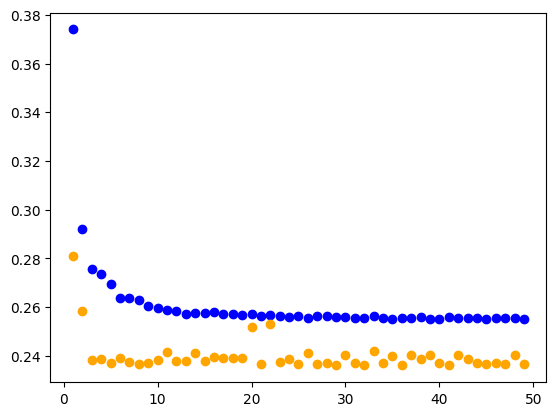

In [112]:
import matplotlib.pyplot as plt 

x=np.linspace(1,len(train_loss),len(train_loss))

plt.scatter(x,train_loss,c="blue")
plt.scatter(x,val_loss,c="orange")

As of now, the best outcome comes with "scaling" the input timeseries by 10000. Maybe adjust the NN a bit? add some linear and conv layers after the RNN? Multiple layers of RNN? We will see. 